# Computational Exercise 2-4: A Surface with so much potential
We are going to construct what is often referred to as an $ab$ $initio$ potential energy surface of the diatomic
molecule carbon monoxide.  That is, we are going to use various electronic structure theories (Hartree-Fock theory, Configuration Interaction theory, and Density Functional theory) to compute the electronic energy at different geometries of a simple diatomic molecule.  We will use the interpolation capabilities of scipy to simplify the evalution of the potential energy at separations for which we did not explicitly evaluate the electronic energy.  We will also use scipy to differentiate the interpolated potential energy surface to obtain the forces acting on the atoms at different separations.  

We will start by importing the necessary libraries:

In [1]:
import numpy as np
import psi4
from matplotlib import pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline

CO R values : [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3]
CO energies : [-99.3251634702825, -99.57698153332763, -99.74563633484908, -99.8575897833609, -99.93044130066, -99.97607436981804, -100.00264748595342, -100.01584985036581, -100.01969338235581, -100.01702310910855, -100.00985995115184, -99.98738918021357, -99.95952028680149, -99.93000178687367, -99.90078738120613, -99.87285077491482, -99.84662338648666, -99.82225413409634, -99.7997551306085, -99.77907033541351, -99.76010449535077, -99.74274038254758, -99.72685487135641, -99.71233179633109]


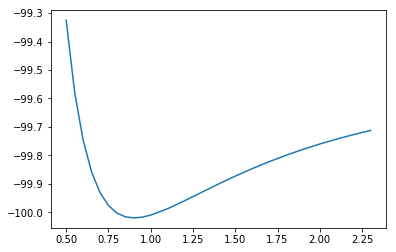

In [5]:
#This is an example of the code we would expect a student to write.  
#If they use the exact same values for rvals, they don't find the well of the PES.  
#The key is that they realize they need to use more R values to get the right shape graph.
mol_tmpl = """H
F 1 **R**"""
r_array = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3]
molecules =[]
E_array = []
for r in r_array:
    molecule = psi4.geometry(mol_tmpl.replace("**R**", str(r)))
    molecules.append(molecule)
for mol in molecules:
    energy = psi4.energy("SCF/cc-pVDZ", molecule=mol)
    E_array.append(energy)
print('CO R values', ':', r_array)
print('CO energies', ':', E_array)
plt.plot(r_array,E_array)

We will now define two arrays: r_array will be an array of values for the $CO$ bond length and E_array will hold the electronic energy values corresponding to each separation.  

Now that you have the raw data, we will interpolate this data using cubic splines.  This will permit us to 
estimate the potential energy at any arbitrary separation between 0.5 and 3.5 Angstroms (roughly 
1 and 5.8 a.u.) with fairly high confidence, and will also allow us to estimate the force 
\begin{equation}
F(r) = -\frac{d}{dr} V(r)
\end{equation}
at any separation between 1.0 and 5.8 a.u. since the derivative of cubic splines are readily available.

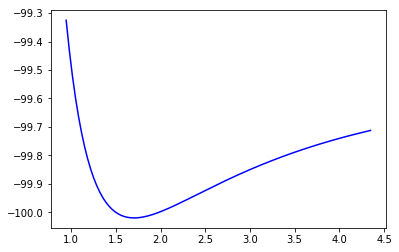

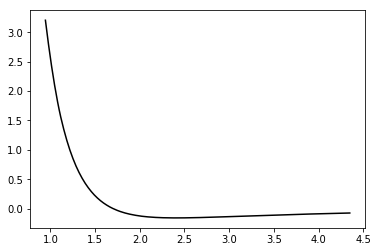

In [14]:
### use cubic spline interpolation
order = 3
### form the interpolator object for the data
for i in range(0,len(r_array)):
    val = r_array[i]/0.529
    r_array[i] = val
    
sE = InterpolatedUnivariateSpline(r_array, E_array, k=order)
### form a much finer grid
r_fine = np.linspace(0.5/0.529,2.3/0.529,200)
### compute the interpolated/extrapolated values for E on this grid
E_fine = sE(r_fine)
### plot the interpolated data
plt.plot(r_fine, E_fine, 'blue')
plt.show()

### take the derivative of potential
fE = sE.derivative()
### force is the negative of the derivative
F_fine = -1*fE(r_fine)

### plot the forces
plt.plot(r_fine, F_fine, 'black')
plt.show()

We can estimate the equilibrium bond length by finding the separation at which the potential is minimum; note this would also be the position that the force goes to zero:
\begin{equation}
\frac{d}{dr} V(r_{eq}) = -F(r_{eq}) = 0,
\end{equation}
but there are artificial local minima in the PES at some levels of theory (e.g. Hartree-Fock) that make finding the zeros in the force problematic.

In [15]:
### Find index of the PES where it has its global minimum
r_eq_idx = np.argmin(E_fine)
### find the value of the separation corresponding to that index
r_eq = r_fine[r_eq_idx]
### print equilibrium bond-length in atomic units and in angstroms
print("Equilibrium bond length is ",r_eq," atomic units")
print("Equilibrium bond length is ",r_eq*0.529," Angstroms")


Equilibrium bond length is  1.6975235344966797  atomic units
Equilibrium bond length is  0.8979899497487436  Angstroms


At this point, take a moment to compare your equilibrium bond length with other teams who have used different levels of theory to compute their potential energy surfaces.  Which equilibrium bond length should be most trustworthy?

Recall now that the Harmonic Oscillator potential, which is a reasonable model for the motion of diatomic atomcs near their equilibrium bond length, is given by
\begin{equation}
V(r) = \frac{1}{2} k r^2
\end{equation}
and that the vibrational frequency of the molecule is given by
\begin{equation}
\nu = \frac{1}{2\pi} \sqrt{\frac{k}{\mu}}
\end{equation}
where $\mu$ is the reduced mass of the molecule and $k$ is known as the force constant.  
We can estimate the force constant as
\begin{equation}
k = \frac{d^2}{dr^2} V(r_{eq}).
\end{equation}

### Question 1:  What is the reduced mass of the CO molecule in atomic units?

### Question 2:  Use your spline fit to the PES of CO to estimate the vibrational frequency of CO.  Express your number in atomic units and also convert to a common spectroscopic unit system of your choosing (wavenumbers, nm, microns, Hertz, THz are all acceptable choices).


Next, we want to actually simulate the dynamics of the CO molecule on this $ab$ $initio$ potential energy surface.  To do so, we need to solve Newton's equations of motion subject to some initial condition for the position (separation) and momentum (in a relative sense) of the particles.  Newton's equations can be written
\begin{equation}
F(r) = \mu \frac{d^2}{dr^2}
\end{equation}
where $\mu$ is the reduced mass in atomic units and $F(r)$ is the Force vs separation in atomic units that was determined previously.  

### Question 3:  What will be the accelation of the bond stretch when C is separated by O by 3 atomic units?  You can express your acceleration in atomic units, also.



If the acceleration, position, and velocity of the bond stretch coordinate are known at some instant in 
time $t_i$, then the position and velocity can be estimated at some later time $t_{i+1} = t_i + \Delta t$:
\begin{equation}
r(t_i + \Delta t) = r(t_i) + v(t_i)\Delta t + \frac{1}{2}a(t_i)\Delta t^2
\end{equation}
and
\begin{equation}
v(t_i + \Delta t) = v(t_i) + \frac{1}{2} \left(a(t_i) + a(t_i + \Delta t)  \right) \Delta t.
\end{equation}
This prescription for updating the velocities and positions is known as the Velocity-Verlet algorithm.  
Note that we need to perform 2 force evaluations per Velocity-Verlet iteration... one corresponding
to position $r(t_i)$ to update the position, and then a second time at the updated position $r(t_i + \Delta t)$
to complete the velocity update.  To be able to define the very first update, an initial position and velocity must be specified.  Typically, these are chosen at random from a sensible range of values.  In this case, we will initialize the position to be a random number between 1.0 and 5.0; for the velocity, we will use the fact that we can estimate the expectation value of kinetic energy for a very similar system (the Harmonic oscillator) in the ground state as follows:
\begin{equation}
\langle T \rangle = \frac{1}{2} E_g,
\end{equation}
where $E_g$ is the ground state of the Harmonic oscillator (this is making use of the Virial theorem).  We can easily
find the ground state energy in the Harmonic oscillator approximation of $CO$ using our frequency calculation described above as
\begin{equation}
E_g = \frac{1}{2} h \nu,
\end{equation}
which implies the kinetic energy expectation value is
\begin{equation}
\langle T \rangle = \frac{1}{8 \pi} h \sqrt{\frac{k}{\mu}}.
\end{equation}
Since we can say classically that the kinetic energy is given by $T = \frac{1}{2}\mu v^2$, we can estimate the velocity of the bond stretch as follows:
\begin{equation}
v = \sqrt{\frac{2 \langle T \rangle}{\mu}} = \sqrt{ \frac{\hbar \sqrt{\frac{k}{\mu}}}{2\mu}}
\end{equation}
where we have simplified using the fact that $\hbar = \frac{h}{2\pi}$.  We will assume that a reasonable
range of velocities spans plus or minus 3 times this "ground-state" velocity.


In [30]:
### get second derivative of potential energy curve... recall that we fit a spline to
### to the first derivative already and called that spline function fE.
cE = fE.derivative()

### evaluate the second derivative at r_eq to get k
k = cE(r_eq)

### define harmonic force
harm_pot = k*(r_fine-r_eq)**2 + sE(r_eq)

### interpolation of harmonic potential
HE = InterpolatedUnivariateSpline(r_fine, harm_pot, k=order)
HF = -HE.derivative()
### define reduced mass of CO as m_C * m_O /(m_C + m_O) where mass is in atomic units (electron mass = 1)
m_F = 34883.
m_H = 1836.
mu = (m_F * m_H)/(m_F + m_H)

### define "ground-state" velocity:
v = np.sqrt( np.sqrt(k/mu)/(2*mu))

### get random position and velocity for CO within a reasonable range
r_init = np.random.uniform(0.75*r_eq,2*r_eq)
v_init = np.random.uniform(-2*v,2*v)

### print initial position and velocity
print("Initial separation is ",r_init, "atomic units")
print("Initial velocity is   ",v_init, "atomic units")
### establish time-step for integration to be 0.2 atomic units... this is about 0.01 femtoseconds
dt = 0.02

### get force on particle 
F_init = -1*fE(r_init)


Initial separation is  2.106606430012386 atomic units
Initial velocity is    -0.0038747119165953824 atomic units


Next we need to define our Velocity-Verlet function and call it to update our position and velocity.  The following partially-complete function will update the position.  You should complete the function to also
update the velocity (note:  Remove lines that update velocity and have students implement them).

[2.1065289195840804, -0.003876330860231493]
[2.1065288676459364, -0.0038815240825287927]


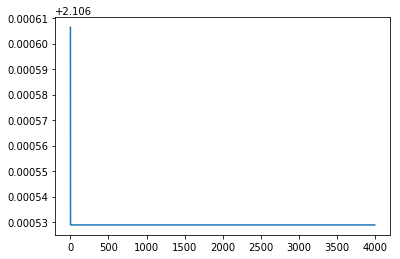

In [34]:
def Velocity_Verlet(r_curr, v_curr, mu, f_interp, dt):
    ### get acceleration at current time
    a_curr = -1*f_interp(r_curr)/mu
    
    ### use current acceleration and velocity to update position
    r_fut = r_curr + v_curr * dt + 0.5 * a_curr * dt**2
    
    ### use r_fut to get future acceleration a_fut
    a_fut = -1*f_interp(r_fut)/mu
    ### use current and future acceleration to get future velocity v_fut
    v_fut = v_curr + 0.5*(a_curr + a_fut) * dt
    
    result = [r_fut, v_fut]
    
    return result

### how many updates do you want to perform?
N_updates = 200000

### Now use r_init and v_init and run velocity verlet update N_updates times, plot results
### these arrays will store the time, the position vs time, and the velocity vs time
r_vs_t = np.zeros(N_updates)
v_vs_t = np.zeros(N_updates)
t_array = np.zeros(N_updates)

### harmonic results
hr_vs_t = np.zeros(N_updates)
hv_vs_t = np.zeros(N_updates)


### first entry is the intial position and velocity
r_vs_t[0] = r_init
v_vs_t[0] = v_init

hr_vs_t[0] = r_init
hv_vs_t[0] = v_init

### first Velocity Verlet update
result_array = Velocity_Verlet(r_init, v_init, mu, fE, dt)
hresult_array = Velocity_Verlet(r_init, v_init, mu, HF, dt)

print(result_array)
print(hresult_array)

### do the update N_update-1 more times
for i in range(1,N_updates):
    tmp = Velocity_Verlet(result_array[0], result_array[1], mu, fE, dt)
    result_array = tmp
    t_array[i] = dt*i
    r_vs_t[i] = result_array[0]
    v_vs_t[i] = result_array[1]
    tmp = Velocity_Verlet(hresult_array[0], hresult_array[1], mu, HF, dt)
    hr_vs_t[i] = hresult_array[0]
    hv_vs_t[i] = hresult_array[1]

### Plot the trajectory of bondlength vs time:
#plt.plot(t_array, r_vs_t, 'red', t_array, hr_vs_t, 'blue')
plt.plot(t_array, hr_vs_t)
plt.show()

### plot the phase space trajectory of position vs momentum
#plt.plot(mu*v_vs_t, r_vs_t, 'blue', mu*hv_vs_t, hr_vs_t, 'purple')
#plt.show()
    
    
    